In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [5]:
data=pd.read_csv("C:/Users/gordee-ext/OneDrive - Louis Dreyfus Company/Desktop/Netology/Моудль 4/Задание 5/4._Ensemble/train.csv")

In [20]:
#data.shape
#data.isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 116.0+ MB


In [27]:
# Уменьшим размер данных для ускорения обучения, возьмем случайную подвыборку 20% данных
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]
    
    
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3        3
v22     117
v24       5
v30       7
v31       4
v47       7
v52      12
v56      38
v66       3
v71       3
v74       2
v75       2
v79      12
v91       6
v107      6
v110      3
v112     22
v113     25
v125     55
dtype: int64


In [28]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [52]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Random Forest
clf_rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [53]:
#Feature importances
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

43     0.203866
10     0.161414
34     0.138197
3      0.076897
98     0.076555
195    0.073980
94     0.060156
73     0.056483
8      0.045392
59     0.026020
78     0.023767
12     0.023103
160    0.018107
114    0.016063
68     0.000000
71     0.000000
69     0.000000
70     0.000000
66     0.000000
72     0.000000
67     0.000000
206    0.000000
65     0.000000
64     0.000000
74     0.000000
62     0.000000
61     0.000000
60     0.000000
58     0.000000
57     0.000000
         ...   
107    0.000000
106    0.000000
105    0.000000
104    0.000000
127    0.000000
128    0.000000
129    0.000000
130    0.000000
151    0.000000
150    0.000000
149    0.000000
148    0.000000
147    0.000000
146    0.000000
145    0.000000
144    0.000000
143    0.000000
142    0.000000
141    0.000000
140    0.000000
139    0.000000
138    0.000000
137    0.000000
136    0.000000
135    0.000000
134    0.000000
133    0.000000
132    0.000000
131    0.000000
0      0.000000
Length: 207, dtype: floa

In [58]:
#Logistig Regression
clf_lr = LogisticRegression(penalty='l1', C=0.1)
clf_lr.fit(X_train, y_train)

C:\Users\gordee-ext\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [80]:
y_pred_test = clf_lr.predict_proba(X_test)[:, 1]
y_pred_train = clf_lr.predict_proba(X_train)[:, 1]

In [75]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train:
ROC AUC: 0.7150
Test:
ROC AUC: 0.6502


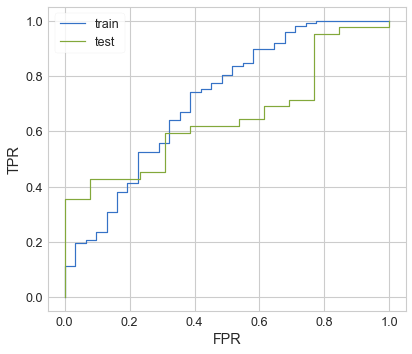

In [76]:
print('Train:')
show_auc(y_train, y_pred_train, 'train')
print('Test:')
show_auc(y_test, y_pred_test, 'test')
plt.legend();

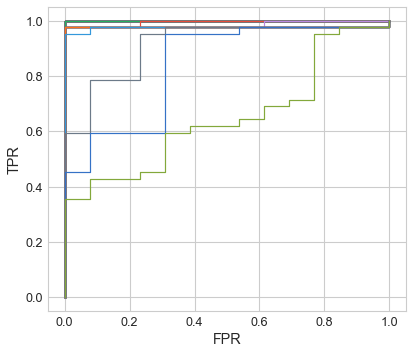

In [81]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_test + (1 - alpha) * y_test
    aucs.append(show_auc(y_test, y_pred_weight, prin=False, plot_label=str(alpha)))
aucs = np.array(aucs)  